# Homework 2

Team Members: Dominik Gausepohl, Maximilian Burr


## 0. Imports and the such


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf
from scipy import signal
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
import pickle 
import csv
from functools import reduce
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

2024-03-08 10:15:32.048601: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


-25.0

## 1. Mmul, Convolution, Multiplier LT


In [14]:
Multiplier_Exact = np.zeros([256,256])
for i in range(-128,128):
    for j in range(-128,128):
        Multiplier_Exact[i+128,j+128]=i*j

def Get_Multiplier(t=0):
    if not isinstance(t, int):
        raise TypeError("Parameter t must be an integer")
    if t < 0 or t > 9:
        raise ValueError("Parameter t must be between 0 and 8")
    elif t==0:
        Multiplier = Multiplier_Exact
    elif(0<t<=9):
        Multiplier = np.load(f"Approximate Mult{t}.npy")
    else:
        ValueError("Parameter t must be between 0 and 8")
    return Multiplier

def My_Mult_Var(a,b,t=0,Multiplier=None):
    if Multiplier is None or not isinstance(Multiplier, np.ndarray): Multiplier=Get_Multiplier(t=t)
    a = np.array(a)
    b = np.array(b)
    a_shape = np.shape(a)
    b = np.reshape(b,a_shape)
    res = np.zeros(a_shape)
    if len(a_shape) == 1: #1D
        for i in range(a_shape[0]):
            res[i] = Multiplier[int(a[i])+128, int(b[i])+128]
    if len(a_shape) == 2: #2D
        for i in range(a_shape[0]):
            for j in range(a_shape[1]):
                res[i] = Multiplier[int(a[i,j])+128, int(b[i,j])+128]
    return res

def My_Matmul_LT_Var(a,b,t=0,Multiplier=None):
    if Multiplier is None or not isinstance(Multiplier, np.ndarray): Multiplier=Get_Multiplier(t=t)
    a = np.array(a)
    b = np.array(b)
    a_shape = np.shape(a)
    b_shape = np.shape(b)
    res = np.zeros([a_shape[0],b_shape[1]])
    for i in range(a_shape[0]):
        for j in range(b_shape[1]):
            res[i,j] = np.sum(My_Mult_Var(a=a[i,:],b=b[:,j],t=t,Multiplier=Multiplier))
    return res

def My_Conv2D_LT_Var(a,b,t=0,Multiplier=None):
    if Multiplier is None or not isinstance(Multiplier, np.ndarray): Multiplier=Get_Multiplier(t=t)
    a = np.array(a)
    b = np.array(b)
    a_shape = np.shape(a)
    b_shape = np.shape(b)
    res_shape1 = np.abs(a_shape[0]-b_shape[0])+1
    res_shape2 = np.abs(a_shape[1]-b_shape[1])+1
    res = np.zeros([res_shape1,res_shape2])
    for i in range(res_shape1):
        for j in range(res_shape2):
            res[i,j] = np.sum(My_Mult_Var(a=np.flip(b),b=a[i:i+b_shape[0],j:j+b_shape[1]],t=t,Multiplier=Multiplier))
    return res

Get_Multiplier(t=9)

array([[ 16384.,  16256.,  16128., ..., -16000., -16128., -16256.],
       [ 16384.,  16257.,  16130., ..., -15999., -16126., -16253.],
       [ 16384.,  16258.,  16132., ..., -15998., -16124., -16250.],
       ...,
       [-15872., -15747., -15622., ...,  15501.,  15626.,  15751.],
       [-15872., -15746., -15620., ...,  15502.,  15628.,  15754.],
       [-16128., -16001., -15874., ...,  15751.,  15878.,  16005.]])

## 2. Unoptimized CNN (deprecated)


## 3. Optimized CNN


In [15]:
# optimized version of CNN
def My_Conv_Layer(input_data,shape,input_channels,weights,bias,t=0,Multiplier=None):
    #Load multiplier
    if Multiplier is None or not isinstance(Multiplier, np.ndarray): Multiplier=Get_Multiplier(t=t)

    output = np.zeros(shape)
    output_channels = shape[2]

    #iterate through each output channel
    for i in range(output_channels):
        #iterate through each input channel
        for j in range(input_channels):
            output[:,:,i] += My_Conv2D_LT_Var(a=np.array(input_data[:,:,j]),b=np.flip(weights[:,:,j,i]),t=t,Multiplier=Multiplier)
            output[:,:,i] += bias[i]
    return output

def My_FC_Layer(input_data,weights,bias,t=0,Multiplier=None):
    return (My_Matmul_LT_Var(a=input_data, b=weights, t=t, Multiplier=Multiplier) + bias)

def My_Quantization_Layer(input):
    return (np.round((input/np.max(input))*127))

def My_ReLu_Layer(input):
    return (np.maximum(0,input))


#k: nr of input data
#t: Type of the Multiplier
def CNN_Var_HP(k,t=0,multiplier=None,vis=False,trainingData=None):
    # Load multiplier
    if multiplier is None or not isinstance(multiplier, np.ndarray): multiplier=Get_Multiplier(t=t)
    # Load data and model
    if trainingData is None:
        # Load MNIST dataset
        mnist = tf.keras.datasets.mnist
        (_,_), (test_images,test_labels) = mnist.load_data() #only load necessary data
        # Load pre-trained CNN model
        model = tf.keras.models.load_model('my_org_model_top4_quant.h5')
        # Get weights and biases
        weights = model.get_weights()
        # Extract features
        extractor_in = keras.Model(inputs=model.inputs, outputs=[layer.input for layer in model.layers])
    else:
        weights=trainingData[0]
        test_images=trainingData[1]
        extractor_in=trainingData[2]
        test_labels=trainingData[3]

    #results array
    res = []
    
    #quantize input data
    z = np.floor(extractor_in(test_images)[0][k]/2)

    del test_images
    del extractor_in
    if trainingData is None: del model
    del trainingData
    
    #Convolution layer, Relu, quantization
    z = My_Conv_Layer(input_data=z,shape=[28,28,64],input_channels=1,weights=weights[0],bias=weights[1],t=t,Multiplier=multiplier)
    z = My_ReLu_Layer(z)
    z = My_Quantization_Layer(z)
    res.append(z)

    z = My_Conv_Layer(input_data=z,shape=[28,28,32],input_channels=64,weights=weights[2],bias=weights[3],t=t,Multiplier=multiplier)
    z = My_ReLu_Layer(z)
    z = My_Quantization_Layer(z)
    if(vis==True): res.append(z)

    z = My_Conv_Layer(input_data=z,shape=[28,28,16],input_channels=32,weights=weights[4],bias=weights[5],t=t,Multiplier=multiplier)
    z = My_ReLu_Layer(z)
    z = My_Quantization_Layer(z)
    if(vis==True): res.append(z)

    z = My_Conv_Layer(input_data=z,shape=[26,26,8],input_channels=16,weights=weights[6],bias=weights[7],t=t,Multiplier=multiplier)
    z = My_ReLu_Layer(z)
    z = My_Quantization_Layer(z)
    if(vis==True): res.append(z)

    z = My_Conv_Layer(input_data=z,shape=[24,24,4],input_channels=8,weights=weights[8],bias=weights[9],t=t,Multiplier=multiplier)
    z = My_ReLu_Layer(z)
    z = My_Quantization_Layer(z)
    if(vis==True): res.append(z)

    #flatten
    z = np.reshape(z, [1,-1])

    #Fully connected, relu and quantize
    z = My_FC_Layer(input_data=z,weights=weights[10],bias=weights[11],t=t,Multiplier=multiplier)
    z = My_ReLu_Layer(z)
    z = My_Quantization_Layer(z)
    if(vis==True): res.append(z)

    z = My_FC_Layer(input_data=z,weights=weights[12],bias=weights[13],t=t,Multiplier=multiplier)
    z = My_ReLu_Layer(z)
    z = My_Quantization_Layer(z)
    if(vis==True): res.append(z)

    # no ReLu in last layer
    z = My_FC_Layer(input_data=z,weights=weights[14],bias=weights[15],t=t,Multiplier=multiplier)
    z = My_Quantization_Layer(z)
    if(vis==True): res.append(z)

    #result
    return np.argmax(z), res, vis, t, k, test_labels[k]


## 4. Run CNN


## Run function


In [16]:
def runCNN(approximators=[0],images=[0],visualzationDataReturn=False,originalImageReturn=False):
    # Load MNIST dataset
    mnist = tf.keras.datasets.mnist
    (_,_), (test_images,test_labels) = mnist.load_data() #only load necessary data
    # Load pre-trained CNN model
    model = tf.keras.models.load_model('my_org_model_top4_quant.h5')
    # Get weights and biases
    weights = model.get_weights()
    # Extract features
    extractor_in = keras.Model(inputs=model.inputs, outputs=[layer.input for layer in model.layers])
    
    trainingData = [weights,test_images,extractor_in,test_labels]
    results = []
    for t in approximators:
        multiplier=Get_Multiplier(t=t)
        for k in images:
            if visualzationDataReturn == False:
                if originalImageReturn == False:
                    predicatedLabels, _, _, approxUsed, imageIndexUsed, expectedLabels = CNN_Var_HP(k=k,t=t,multiplier=multiplier,vis=False,trainingData=trainingData)
                    results.append([predicatedLabels, expectedLabels, approxUsed, imageIndexUsed])
                elif originalImageReturn == False:
                    predicatedLabels, originalImage, _, approxUsed, imageIndexUsed, expectedLabels = CNN_Var_HP(k=k,t=t,multiplier=multiplier,vis=True,trainingData=trainingData)
                    results.append([predicatedLabels, originalImage[0], expectedLabels, approxUsed, imageIndexUsed])
            elif visualzationDataReturn == True:
                results.append(CNN_Var_HP(k=k,t=t,multiplier=multiplier,vis=visualzationDataReturn,trainingData=trainingData))
            print(f"Image {k} finished")
        print(f"Aproximator {t} finished")

    del test_images
    del extractor_in
    del trainingData
    del model
    del mnist
    return results

def getMnistImageIndexes(testLabel):
    mnist = tf.keras.datasets.mnist
    (_,_), (_,test_labels) = mnist.load_data() #only load necessary data
    indexes = np.where(test_labels == testLabel)
    indexes = indexes[0].tolist()
    del test_labels
    del mnist


In [20]:
results_exact = runCNN(approximators=[0],images=range(0,300),visualzationDataReturn=True,originalImageReturn=False)


KeyboardInterrupt: 

## Do run and save run data to file


In [22]:
results = runCNN(approximators=[0,9],images=range(0,300),visualzationDataReturn=True,originalImageReturn=False)
 

Image 0 finished
Image 1 finished
Image 2 finished
Image 3 finished
Image 4 finished
Image 5 finished
Image 6 finished
Image 7 finished
Image 8 finished
Image 9 finished
Image 10 finished
Image 11 finished
Image 12 finished
Image 13 finished
Image 14 finished
Image 15 finished
Image 16 finished
Image 17 finished
Image 18 finished
Image 19 finished
Image 20 finished
Image 21 finished
Image 22 finished
Image 23 finished
Image 24 finished
Image 25 finished
Image 26 finished
Image 27 finished
Image 28 finished
Image 29 finished
Image 30 finished
Image 31 finished
Image 32 finished
Image 33 finished
Image 34 finished
Image 35 finished
Image 36 finished
Image 37 finished
Image 38 finished
Image 39 finished
Image 40 finished
Image 41 finished
Image 42 finished
Image 43 finished
Image 44 finished
Image 45 finished
Image 46 finished
Image 47 finished
Image 48 finished
Image 49 finished
Image 50 finished
Image 51 finished
Image 52 finished
Image 53 finished
Image 54 finished
Image 55 finished
Im

## Save results to file


In [23]:
with open('lenet_results.pkl', 'wb') as file: 
    pickle.dump(results, file) 

## Load results from file


In [13]:
file_names = ['lenet_results.pkl']
results = []
for file_name in file_names:
    with open(file_name, 'rb') as file: 
        results += pickle.load(file) 



print(results)

[[[0.245, 0.245, 0.235, 0.225, 0.225, 0.235, 0.22, 0.2, 0.23, 0.205, 0.2, 0.12], 2], [[0.245, 0.245, 0.235, 0.225, 0.225, 0.235, 0.22, 0.2, 0.23, 0.205, 0.2, 0.12], 3], [[0.245, 0.245, 0.235, 0.225, 0.225, 0.235, 0.22, 0.2, 0.23, 0.205, 0.2, 0.12], 4], [[0.245, 0.245, 0.235, 0.225, 0.225, 0.235, 0.22, 0.2, 0.23, 0.205, 0.2, 0.12], 5], [[0.245, 0.245, 0.235, 0.225, 0.225, 0.235, 0.22, 0.2, 0.23, 0.205, 0.2, 0.065], 6], [[0.245, 0.245, 0.235, 0.225, 0.225, 0.235, 0.22, 0.2, 0.23, 0.205, 0.2, 0.105], 7], [[0.245, 0.245, 0.235, 0.225, 0.225, 0.235, 0.22, 0.2, 0.23, 0.205, 0.2, 0.105], 8], [[0.245, 0.245, 0.235, 0.225, 0.225, 0.235, 0.22, 0.2, 0.23, 0.205, 0.2, 0.105], 9], [[0.245, 0.245, 0.235, 0.225, 0.225, 0.235, 0.22, 0.2, 0.23, 0.205, 0.2, 0.105], 10], [[0.245, 0.245, 0.235, 0.225, 0.225, 0.235, 0.22, 0.2, 0.23, 0.205, 0.2, 0.105], 11], [[0.245, 0.245, 0.235, 0.225, 0.225, 0.235, 0.22, 0.2, 0.23, 0.205, 0.2, 0.105], 12]]


## 5. Plot results of CNN Run


## Plotting function


In [24]:
def plotResults(cnnResults,generate_individual_figures=False,generate_composed_figure=True,save_figures=False):
    res= cnnResults
    #independent plot for each intermediate representation
    if (res[0][2] == True):#visualization==true
        for i in range(len(res)):
            if generate_individual_figures == True:
                #Individual pictures
                size = int(np.ceil(np.sqrt(len(res[i][1])))) #nr of subplots needed
                fig, axes = plt.subplots(size, size, figsize=(8, 8)) # generate subplots
                fig.suptitle(f'Approximate Multiplier Nr {res[i][3]}\nPredicted {res[i][0]}')#title
                axes = axes.flatten() # flatten the axes array

                for j in range(size*size):#loop over the whole subplot array
                    ax=axes[j]
                    if j < len(res[i][1]):
                            if len(res[i][1][j].shape) == 3:#2D
                                ax.imshow(np.average((res[i][1][j]),axis=-1))  # Plot the image
                            else:#1D
                                ax.plot(res[i][1][j][0])
                            ax.set_title(f'Vis{j}')  # Set a title for the subplot
                            ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6)) # Set max number of ticks per axis
                    else: ax.axis('off')
                plt.tight_layout()
                if (save_figures==True): plt.savefig(f'MNIST-{res[i][4]}_Approx-Mul-{res[i][3]}.png',format='png')
        if generate_composed_figure == True:
            #Comparison picture
            fig, axes = plt.subplots(len(res), len(res[i][1]), figsize=(len(res[i][1])*2.5, len(res)*2.5)) # generate subplots
            fig.suptitle("Comparison picture of all results", y=1.05)
            axes = axes.flatten() # flatten the axes array
            counter = 0
            for i in range(len(res)):
                for j in range(len(res[i][1])):
                    ax=axes[counter]
                    counter+=1
                    if j < len(res[i][1]):
                            if len(res[i][1][j].shape) == 3:#2D
                                ax.imshow(np.average((res[i][1][j]),axis=-1))  # Plot the image
                            else:#1D
                                ax.plot(res[i][1][j][0])
                            ax.set_title(f'Approx Mult Nr {res[i][3]}\nPredicted {res[i][0]}')  # Set a title for the subplot
                            ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6)) # Set max number of ticks per axis
                    else: ax.axis('off')
            plt.tight_layout()
            if (save_figures==True): plt.savefig(f'Comparison.png',format='png')

    else:#visualization==false
        for i in range(len(res)):
            fig = plt.figure(figsize=(2, 2))
            plt.imshow(np.average(res[i][1][0],axis=-1))
            plt.title(f'Approximate Multiplier Nr {res[i][3]}\nPredicted {res[i][0]}')
            if (save_figures==True): plt.savefig(f'MNIST-{res[i][4]}_Approx-Mul-{res[i][3]}.png',format='png')
    return

## Do plot


In [25]:
plotResults(results,save_figures=True)

ValueError: Image size of 2000x150000 pixels is too large. It must be less than 2^16 in each direction.

Error in callback <function _draw_all_if_interactive at 0x7668a5db3060> (for post_execute), with arguments args (),kwargs {}:


ValueError: Image size of 2000x150000 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 2000x150000 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2000x150000 with 4800 Axes>

# 6. Calculate Error


## Calculate Error for each image for each layer for each approximator and write to .csv


In [ ]:

#Restructure data
nrApprox = 8
nrImages = 300
error = []
for h in range(nrImages):#all classified images
    error.append([])
    for i in range(len(results[0][1])):#layers to visualize
        error[h].append([])
        for j in range(0,nrApprox,8):#all aproximators
            error[h][i].append(np.sum(np.abs(results[h+nrImages*(j+1)][1][i]-results[h][1][i])))#approximated calculation vs orig calculation gives error

#Write to csv
with open('output.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    header = ["imageNr","layerNr", "approx9"]
    writer.writerow(header)

    for i, image in enumerate(error):#for each image
        for j, layer in enumerate(image):#for each layer of each image
            values = []
            for approximator in layer:#for each approximator of each layer of each image
                values.append(approximator)
            writer.writerow([i,j+1] + values)#write the image number, layer number and approximator values



## Average Cummulative Error per Layer


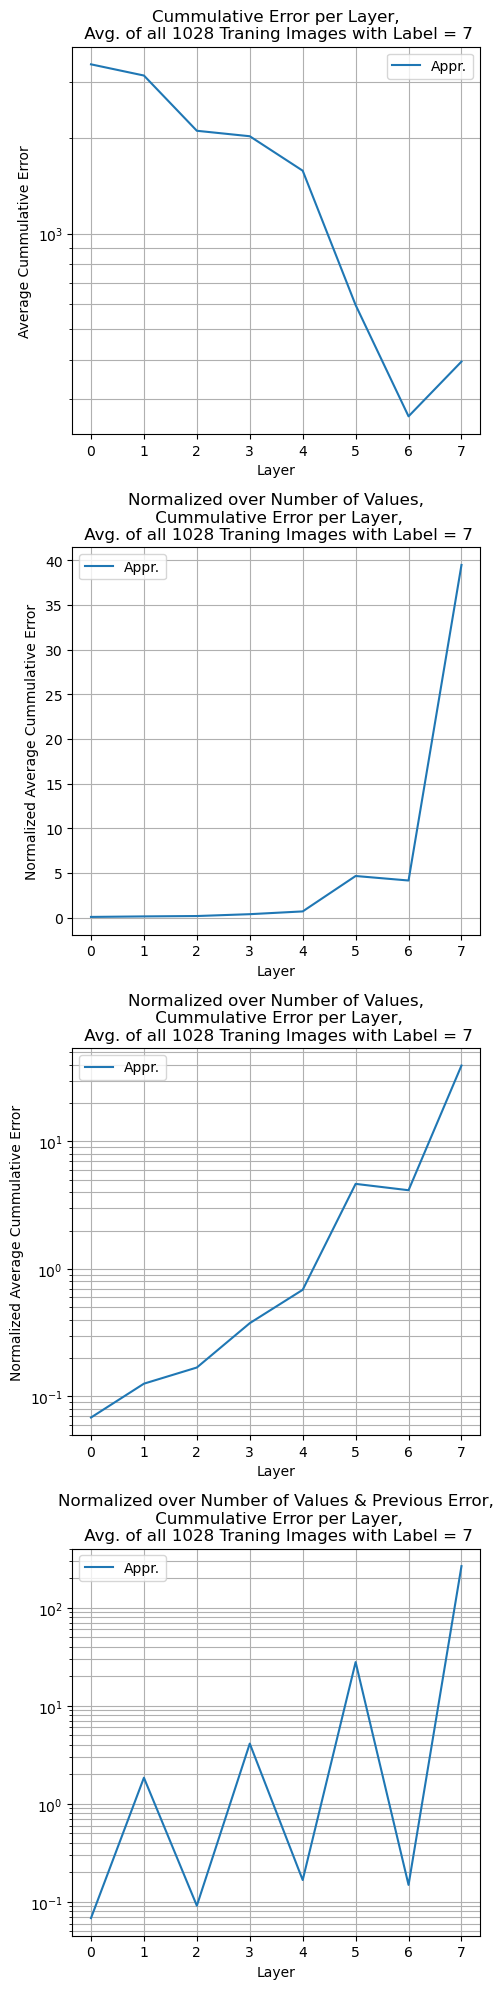

In [ ]:
averagesNorm = []
averages = []
nrLayers = len(error[0])
nrApproximators = len(error[0][0])


layerShapes=[[28, 28, 64],[28, 28, 32],[28, 28, 16],[26, 26, 8],[24, 24, 4],[1, 128],[1, 64],[1, 10]]
layerNrValues=[]
for layer in layerShapes:
    layerNrValues.append(reduce(lambda x, y: x*y, layer))

for j in range(nrLayers):
    averagesNorm.append([])
    averages.append([])
    for k in range(nrApproximators):
        # Collect the approximator values for the j-th layer and k-th approximator across all images
        values = [image[j][k] for image in error]
        averagesNorm[j].append(np.average(values)/layerNrValues[j])
        averages[j].append(np.average(values))

#Plot each approximator
fig, axes = plt.subplots(4, 1, figsize=(5, 20)) # generate subplots
#create labels
labels=[]
for i in range(nrApproximators):
    labels.append(f"Appr.")


for i in range(nrApproximators):
    errors = [layer[i] for layer in averages]
    errorsNorm = [layer[i] for layer in averagesNorm]
    errorsNormNorm = [layer[i] for layer in averagesNorm]
    for i in range(1,len(errorsNormNorm)):
        errorsNormNorm[i] /= errorsNormNorm[i-1]

    axes[0].plot(errors)
    axes[1].plot(errorsNorm)
    axes[2].plot(errorsNorm)
    axes[3].plot(errorsNormNorm)

for i in range(len(axes)):
    axes[i].set_xlabel('Layer')
    axes[i].grid(which='minor', axis='y')
    axes[i].grid(which='major', axis='y')
    axes[i].grid(which='major', axis='x')
    axes[i].legend(labels)

axes[0].set_yscale('log')
axes[1].set_yscale('linear')
axes[2].set_yscale('log')
axes[3].set_yscale('log')


axes[0].set_title('Cummulative Error per Layer,\n Avg. of all 1028 Traning Images with Label = 7')
axes[1].set_title('Normalized over Number of Values,\n Cummulative Error per Layer,\n Avg. of all 1028 Traning Images with Label = 7')
axes[2].set_title('Normalized over Number of Values,\n Cummulative Error per Layer,\n Avg. of all 1028 Traning Images with Label = 7')
axes[3].set_title('Normalized over Number of Values & Previous Error,\n Cummulative Error per Layer,\n Avg. of all 1028 Traning Images with Label = 7')


axes[0].set_ylabel('Average Cummulative Error')
axes[1].set_ylabel('Normalized Average Cummulative Error')
axes[2].set_ylabel('Normalized Average Cummulative Error')
plt.tight_layout()
plt.savefig('error.png',format='png')




# 7. Calculate Accuracy


## Test Function


In [49]:
def testResult(result, checkForLabel):
    predictedLabel = result[1][0]
    testLabel = result[1][5]    # Test TP
    t = result[1][3]
    k = result[1][4]
    if testLabel == predictedLabel and predictedLabel == checkForLabel:
        return ("TP", predictedLabel, testLabel, checkForLabel,t,k)
    # Test TN
    elif testLabel == predictedLabel and predictedLabel != checkForLabel:
        return ("FN", predictedLabel, testLabel, checkForLabel,t,k)
    # Test FP
    elif testLabel != predictedLabel and predictedLabel == checkForLabel:
        return ("FP", predictedLabel, testLabel, checkForLabel,t,k)
    # Test FN
    elif testLabel != predictedLabel and predictedLabel != checkForLabel:
        return ("TN", predictedLabel, testLabel, checkForLabel,t,k)
        
def calcPrecision(testResultsforApprox):

    truePositives = len((list(filter(lambda x: x[0] == "TP", testResultsforApprox))))
    falsePositives = len((list(filter(lambda x: x[0] =="FP", testResultsforApprox))))
    precision = truePositives/(falsePositives+truePositives)

    return precision

def calcAccuracy(testResultsforApprox):

    image_count = len(testResultsforApprox) 
    trues = len(list(filter(lambda x: x[0] == "TP" or x[0] == "TN" , testResultsforApprox)))
    accuracy = trues/image_count
    return accuracy

def calcRecall(testResultsforApprox):

    truePositives = len(list(filter(lambda x: x[0] == "TP", testResultsforApprox)))
    falseNegatives = len(list(filter(lambda x: x[0] == "FN", testResultsforApprox)))
    recall = truePositives/(truePositives+falseNegatives)
    return recall

def calcF1(precision,recall):
    
    f1 = 2*((precision*recall)/(precision+recall))
    return f1



def runTest(results, checkForLabel,approximator=0):
    print(f"Test for label: {checkForLabel}")
    approxSublists = []
    finalResults = []
    #Sort results for Aproximater and pack into sublists
    
    print(f"Check for Approximator {approximator}")
    testResults = []
    #print(f"Test for Apprixmator {i}")
    approxSublists.append(list(filter(lambda x: x[3] == approximator, results)))
    for result in enumerate(approxSublists[0]):
        #print(f"Test for Image: {result[1][4]} with Approximator {result[1][3]}")
        testResults.append(testResult(result,checkForLabel))
    finalResults.append(testResults)
    accuracy = calcAccuracy(testResults)
    precision = calcAccuracy(testResults)
    recall = calcRecall(testResults)
    f1 = calcF1(precision,recall)
    confussion_matrix = doConfussionMatrix(testResults,checkForLabel)
    print(f"Accuracy {accuracy}")
    print(f"Precision: {precision}" )
    print(f"Recall: {recall}")
    print(f"F1: {f1}")
    print("\n")
    
    return finalResults

import matplotlib.pyplot as plt
import seaborn as sns

def doConfussionMatrix(testResultsforApprox, checkForLabel):
    truePositives = len(list(filter(lambda x: x[0] == "TP", testResultsforApprox)))
    trueNegatives =  len(list(filter(lambda x: x[0] == "TN", testResultsforApprox)))
    falsePositives = len(list(filter(lambda x: x[0] == "FP", testResultsforApprox)))
    falseNegatives = len(list(filter(lambda x: x[0] == "FN", testResultsforApprox)))

    cm = [[falsePositives, truePositives],
          [trueNegatives, falseNegatives]]
    ax = sns.heatmap(cm, annot=True, fmt='d',annot_kws={"size": 16})

    # Offset the x-axis labels by 0.5
    # x_labels = ['True Negatives', 'False Positive']
    # y_labels = ['True Positives', 'False Negative']
    # x_ticks = [i + 0.5 for i in range(len(cm[0]))]
    # y_ticks = [i + 0.5 for i in range(len(cm[0]))]

    # ax.set_xticks(x_ticks)
    # ax.set_yticks(y_ticks)
    # ax.set_xticklabels(x_labels, rotation=0)
    # ax.set_yticklabels(y_labels)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    plt.title("Confusion Matrix with Exact Calculations", fontsize=16)



    plt.show()




## Do Tests and calculate accuracy


Test for label: 7
Check for Approximator 9


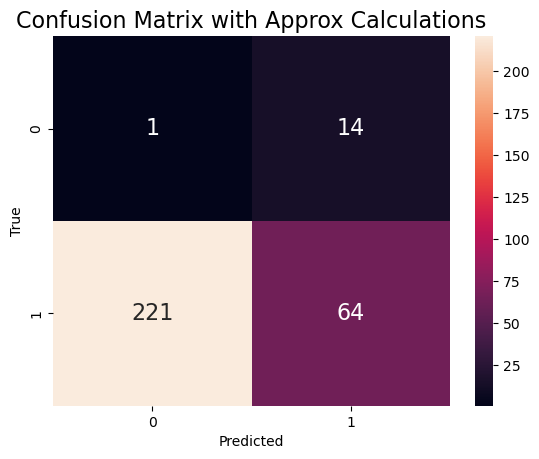

Accuracy 0.7833333333333333
Precision: 0.7833333333333333
Recall: 0.1794871794871795
F1: 0.2920550377274745




In [47]:
finalResults = [] 

finalResults.append(runTest(results=results,checkForLabel=7,approximator=9))





Test for label: 7
Check for Approximator 0


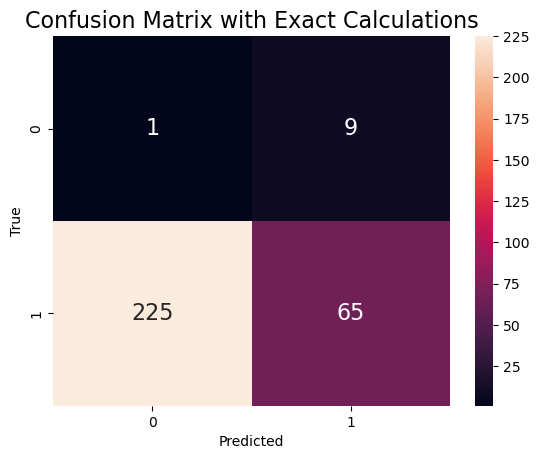

Accuracy 0.78
Precision: 0.78
Recall: 0.12162162162162163
F1: 0.210431654676259




In [50]:
finalResults.append(runTest(results=results,checkForLabel=7,approximator=0))


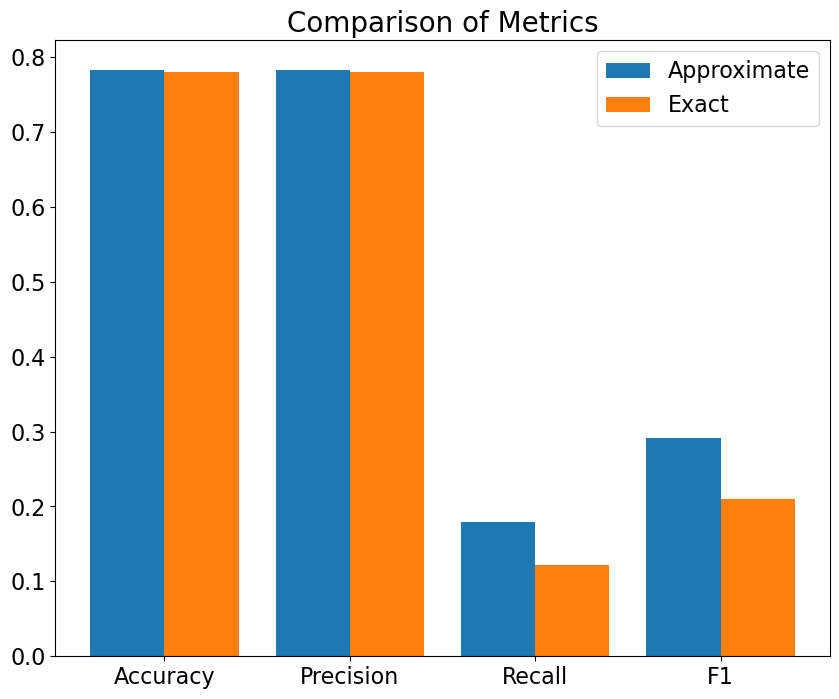

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
values1 = [0.7833333333333333, 0.7833333333333333, 0.1794871794871795, 0.2920550377274745]
values2 = [0.78, 0.78, 0.12162162162162163, 0.210431654676259]

# Create a figure and set the title
fig = plt.figure(figsize=(10, 8))
plt.title('Comparison of Metrics', fontsize=20)

# Create an index for each metric
x = np.arange(len(metrics))

# Create the bar chart
plt.bar(x - 0.2, values1, 0.4, label='Approximate')
plt.bar(x + 0.2, values2, 0.4, label='Exact')

# Set the x-ticks to be the metrics
plt.xticks(x, metrics, fontsize=16)

# Set the y-ticks fontsize
plt.yticks(fontsize=16)

# Add a legend
plt.legend(fontsize=16)

# Show the plot
plt.show()